# Studying dependance of the hysteresis cycle on voltage sweep speed

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import time
import datetime
from glob2 import glob

from importlib import reload
from instruments import instek3032
from instruments import yoko7651
from instruments import zvk
from instruments import fsva

%cd S:\analysis\python\notebooks\tunable-filter\speed_study

# -------------- SOME USEFUL FUNCTIONS

def get_max_peaks(amps, f_list):
    if f_list.ndim == 1 : 
        v_shape, _ = amps.shape
        max_freqs = np.zeros(v_shape)
        max_values = np.zeros(v_shape)
        for i in range(v_shape) :
            v_slice = amps[i, :]
            max_freqs[i] = f_list[np.argmax(v_slice)]
            max_values[i] = np.max(v_slice)
        return max_freqs, max_values
    
    elif f_list.ndim == 2:
        v_shape, _ = amps.shape
        max_freqs = np.zeros(v_shape)
        max_values = np.zeros(v_shape)
        for i in range(v_shape) :
            v_slice = amps[i, :]
            max_freqs[i] = f_list[i, np.argmax(v_slice)]
            max_values[i] = np.max(v_slice)
        return max_freqs, max_values
    else : raise ValueError("f_list must have one or two dims.")

def get_band_pass_position(amps_dB, f_list, cutoff = 3):
    if f_list.ndim == 1 : 
        v_shape, _ = amps_dB.shape
        band_freqs = np.zeros((v_shape, 2))
        max_values = np.zeros(v_shape)
        for i in range(v_shape) :
            v_slice = amps_dB[i, :]
            max_val = np.max(v_slice)
            max_values[i] = max_val
            pass_band = np.nonzero(v_slice >= (max_val - cutoff)) # get indices of values that are less that 3dB from plateau value
            band_freqs[i, :] = f_list[np.min(pass_band)], f_list[np.max(pass_band)]
        return band_freqs, max_values
    
    elif f_list.ndim == 2:
        v_shape, _ = amps_dB.shape
        band_freqs = np.zeros((v_shape, 2))
        max_values = np.zeros(v_shape)
        for i in range(v_shape) :
            v_slice = amps_dB[i, :]
            max_val = np.max(v_slice)
            max_values[i] = max_val
            pass_band = np.nonzero(v_slice >= (max_val - cutoff)) # get indices of values that are less that 3dB from plateau value
            band_freqs[i, :] = f_list[i, np.min(pass_band)], f_list[i, np.max(pass_band)]
        return band_freqs, max_values
    else : raise ValueError("f_list must have one or two dims.")
    
def get_band_pass_single_trace(amps_dB, f_list, cutoff = 3):
    max_val = np.max(amps_dB)
    pass_band = np.nonzero(amps_dB >= (max_val - cutoff)) # get indices of values that are less that 3dB from plateau value
    band_freqs = f_list[np.min(pass_band)], f_list[np.max(pass_band)]
    return band_freqs, max_val

def theoretical_peak_position(V):
    return (38e9/10)*V + 2e9

S:\analysis\python\notebooks\tunable-filter\speed_study


# TODO Measurement

In [ ]:
reload(zvk)
reload(yoko7651)
# reload(instek3032)

vna = zvk.Zvk("GPIB1::20::INSTR")
# instek = instek3032.Instek3032("ASRL5::INSTR")
yoko = yoko7651.Yoko7651('GPIB1::1::INSTR')

# ------------------------ PARAMETERS
n_voltage_points = 2001
n_sweep_points = 2001
f_start = 10e6
f_stop  = 40e9

saving_frequency = 100

bias_values = np.linspace(0, 10, n_voltage_points)
f_values = np.linspace(f_start, f_stop, n_sweep_points)

amps_increasing_V = np.zeros((n_voltage_points, n_sweep_points))
phases_increasing_V = np.zeros_like(amps_increasing_V)

amps_decreasing_V = np.zeros_like(amps_increasing_V)
phases_decreasing_V = np.zeros_like(amps_increasing_V)

z_increasing_V = np.zeros_like(amps_increasing_V, dtype = 'complex')
z_decreasing_V = np.zeros_like(amps_increasing_V, dtype = 'complex')



# ------------------------ INSTRUMENT SETUP (if needed)

# instek.dc_offset = 0
# instek.load = "INF"
# instek.unit = "VPP"
# instek.apply_waveform("DC")

yoko.source_voltage()
yoko.voltage(0)
yoko.range_voltage(12)
yoko.output(True)


vna.freq_start_stop = [f_start, f_stop]
vna.sweep_points = n_sweep_points
vna.power = -15 #dBm
vna.averaging = 0
vna.sweep_count = 1
vna.bandwidth = 10e3

# ------------------------ LOADING DATA 
filename = 'freq_dep_study'
wavename = filename
comment = 'no time dependence study for now'

tracename = 'CH1DATA'
S_parameter = 'S21'
ch = 1

when = datetime.datetime.now()
meta = {
    'center': vna.center_freq,
    'span': vna.freq_span,
    'start': vna.start_freq,
    'stop': vna.stop_freq,
    'nb_points': vna.sweep_points,
    'sweep_count': vna.sweep_count,
    "sweep_duration":vna.sweep_duration,
    "averaging": vna.averaging,
    'VBW': vna.bandwidth,
    'power': vna.power,
    'S_parameter': S_parameter,
    'datetime': when
}

single_sweep_time = 1.1*vna.sweep_duration
total_time = 2*single_sweep_time*(n_voltage_points + 0.1)

print(f"Expected duration of measurement : {total_time:.0f} s")

filename_final = input(f'Filename ? (or Enter to cancel, or Space+Enter for {filename}): ')
if filename_final == '':
    print("measurement cancelled.")
    pass
else:
    if filename_final == ' ':
        filename_final = filename + when.strftime('%Y%m%d-%Hh%Mmin%Ss')
        
    ######## INCREASING V PASS
    
    for i, v in enumerate(bias_values):
        
        # instek.dc_offset = v
        yoko.voltage(v)
        time.sleep(0.1)
        
        vna.trigger()
        time.sleep(single_sweep_time)
        
        while vna.busy() :
            time.sleep(0.01)
        
        _, z = vna.get_data(trace = tracename)
        
        z_increasing_V[i, :] = z
        
        phases_increasing_V[i, :] = np.angle(z)
        amps_increasing_V[i, :] = 20*np.log10(np.abs(z))
        
        if i % saving_frequency == 0 : 
            np.savez(filename_final, f_values=f_values, bias_values = bias_values, z_increasing_V = z_increasing_V, z_decreasing_V = z_decreasing_V, meta=meta, comment=comment)
        

    ######## DECREASING V PASS
    
    for i, v in enumerate(np.flip(bias_values)):
        
        # instek.dc_offset = v
        yoko.voltage(v)
        time.sleep(0.1)
        
        vna.trigger()
        time.sleep(single_sweep_time)
        
        while vna.busy() :
            time.sleep(0.01)
        
        _, z = vna.get_data(trace = tracename)
        
        z_decreasing_V[-(i+1), :] = z 
        
        phases_decreasing_V[-(i+1), :] = np.angle(z)
        amps_decreasing_V[-(i+1), :] = 20*np.log10(np.abs(z))
        
        if i % saving_frequency == 0 : 
            np.savez(filename_final, f_values=f_values, bias_values = bias_values, z_increasing_V = z_increasing_V, z_decreasing_V = z_decreasing_V, meta=meta, comment=comment)
    
    np.savez(filename_final, f_values=f_values, bias_values = bias_values, z_increasing_V = z_increasing_V, z_decreasing_V = z_decreasing_V, meta=meta, comment=comment)
    
    f_max_increasing, _ = get_max_peaks(amps_increasing_V, f_values)
    f_max_decreasing, _ = get_max_peaks(amps_decreasing_V, f_values)

    line = (f_max_increasing[-1] - f_max_increasing[0])/(bias_values[-1] - bias_values[0]) * bias_values + f_max_increasing[0]

    fig = plt.figure(dpi = 100, figsize = (9, 4), constrained_layout = True)
    gs = fig.add_gridspec(1, 2)
    ax_l = fig.add_subplot(gs[:, 0])
    ax_r = fig.add_subplot(gs[:, 1])

    im_l_i = ax_l.imshow(amps_increasing_V.T, origin = 'lower', extent = [bias_values[0], bias_values[-1], f_start*1e-9, f_stop*1e-9], aspect = 'auto', interpolation = "none", vmax = -10, vmin = -80, alpha = 1)
    #im_l_d = ax_l.imshow(amps_decreasing_V.T, origin = 'lower', extent = [bias_values[0], bias_values[-1], f_start*1e-9, f_stop*1e-9], aspect = 'auto', interpolation = "none", vmax = -10, vmin = -80, alpha = 1)
    fig.colorbar(im_l_i, ax = ax_l, extend = 'both', alpha = 1, label = r'$\left| S_{21}\right| (dBm)$')
    ax_l.set_title("increasing sweep spectra")
    # ax_l.plot(bias_values, f_max_increasing/1e9, label = 'Increasing V')
    # ax_l.plot(bias_values, f_max_decreasing/1e9, label = "Decreasing V")
    # ax_l.legend()
    ax_l.set_xlabel(r"$V_{DC}$ (V)")
    ax_l.set_ylabel(r"$f$ (GHz)")



    ax_r.set_xlabel(r"$V_{DC}$ (V)")
    ax_r.set_ylabel(r"$\Delta f$ (MHz)")
    ax_r.yaxis.tick_right()
    ax_r.yaxis.set_label_position("right")
    ax_r.set_title("Hysteresis")
    ax_r.axhline(color = 'gray', ls = '--')
    ax_r.plot(bias_values, (f_max_increasing - line)/1e6, label = "Deviation\n from lin : " r"$\nearrow$")
    ax_r.plot(bias_values, (f_max_decreasing - line)/1e6, label = "Deviation\n from lin : " r"$\searrow$")
    ax_r.legend()
    ax_r.grid(True)
    
    fig.savefig(filename_final + '.png')

del vna
# del instek
del yoko

In [46]:
yoko = yoko7651.Yoko7651('GPIB1::1::INSTR')


Instrument initialized.
VISA resource: GPIB1::1::INSTR


In [50]:
del yoko

# Data analysis

### Data done by hand

In [13]:
npz_pathes = glob(r"S:\analysis\python\notebooks\tunable-filter\speed_study\*.npz")
npz_filenames = [path.split("\\")[-1][:-4] for path in npz_pathes]
print(npz_filenames)
npz_files = {npz_filenames[i] : dict(np.load(filename, allow_pickle = True)) for i, filename in enumerate(npz_pathes)}
print(npz_files["speed20220517-17h08min10s"]['meta'])

['speed20220517-16h52min36s', 'speed20220517-16h56min46s', 'speed20220517-16h58min35s', 'speed20220517-16h59min43s', 'speed20220517-17h02min23s', 'speed20220517-17h03min37s', 'speed20220517-17h05min32s', 'speed20220517-17h08min10s']
{'center': 21000000000.0, 'span': 200000000.0, 'start': 20900000000.0, 'stop': 21100000000.0, 'nb_points': 101, 'VBW': 10000.0, 'power': '-20\n', 'S_parameter': 'S21', 'datetime': datetime.datetime(2022, 5, 17, 17, 8, 10, 619545), 'yoko_sweep_duration': 10, 'yoko, sweep_max': 7}


Switching to l
Switching to l
Switching to l
Switching to l
Switching to r
Switching to r
Switching to r
Switching to r


Text(0.5, 1.0, 'Peak frequency difference evolution\n(after - before)')

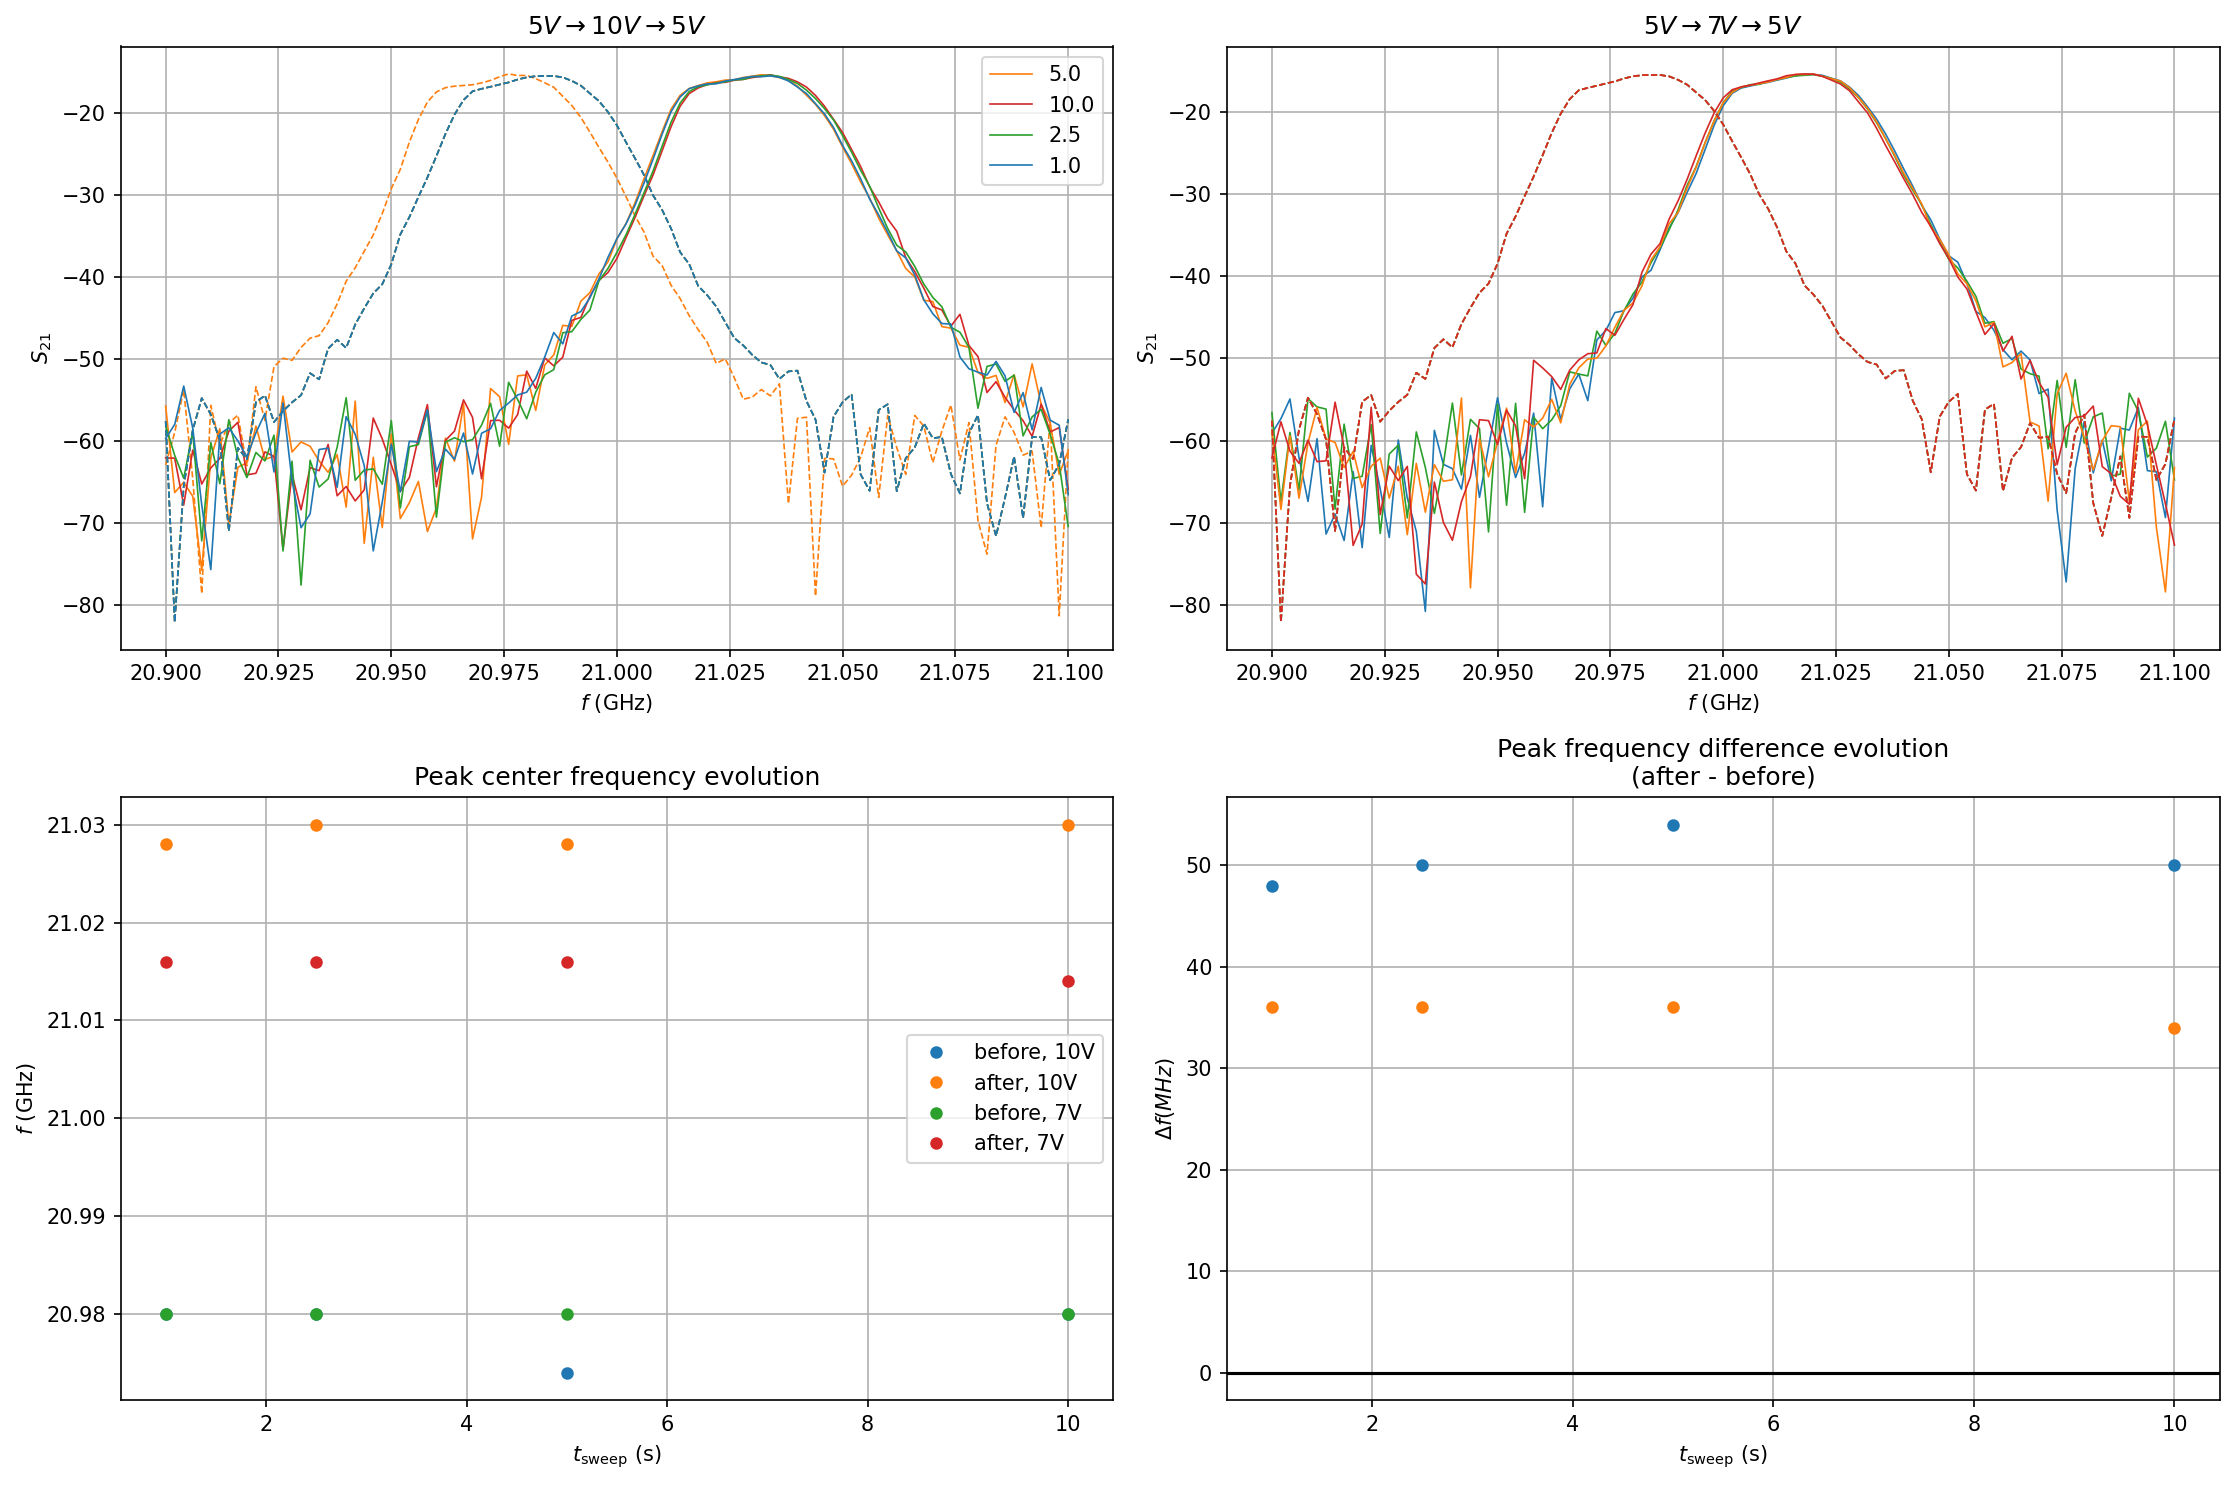

In [43]:
fig, ax = plt.subplots(2, 2, figsize = (15, 10), dpi = 150, tight_layout = True)
ax_l, ax_r = ax[0, :]
ax_bl, ax_br = ax[1, :]

for axis in [ax_l, ax_r, ax_bl, ax_br] : 
    axis.grid(True)

for axis in [ax_l, ax_r]:
    axis.set_xlabel(r"$f$ (GHz)")
    axis.set_ylabel(r"$S_{21}$")

for axis in [ax_bl, ax_br]:
    axis.set_xlabel(r"$t_{\mathrm{sweep}}$ (s)")

ax_bl.set_ylabel(r"$f$ (GHz)")
ax_br.set_ylabel(r"$\Delta f (MHz)$")
    
orig_peak_centers_10V = []
peak_centers_10V = []
sweep_dur_10V = []

orig_peak_centers_7V = []
peak_centers_7V = []
sweep_dur_7V = []

colors = {1: "tab:blue", 2.5: "tab:green", 5:"tab:orange", 10:"tab:red"}
for file in npz_files.values() :
    
    f = file["f"]*1e-9
    z_orig = 20*np.log10(np.abs(file["z_orig"]))
    band_center_orig = np.mean(get_band_pass_single_trace(z_orig, f)[0])
    
    z = 20*np.log10(np.abs(file["z"]))
    band_center = np.mean(get_band_pass_single_trace(z, f)[0])
    
    sweep_duration = file['meta'].item()['yoko_sweep_duration']
    
    if "yoko, sweep_max" in file["meta"].item().keys() and file['meta'].item()['yoko, sweep_max'] == 7:
        print("Switching to r")
        current_ax = ax_r
        current_ax_b = ax_br
        
        orig_peak_centers_7V.append(band_center_orig)
        peak_centers_7V.append(band_center)
        sweep_dur_7V.append(sweep_duration)
        
    else : 
        print('Switching to l')
        current_ax = ax_l
        current_ax_b = ax_bl
        
        orig_peak_centers_10V.append(band_center_orig)
        peak_centers_10V.append(band_center)
        sweep_dur_10V.append(sweep_duration)
    
    current_ax.plot(f, z_orig, color = colors[sweep_duration], ls = '--', lw = 0.8)
    current_ax.plot(f, z, color = colors[sweep_duration], label = f"{sweep_duration:.1f}", lw = 0.8)
    
ax_l.legend()



sweep_dur_10V = np.array(sweep_dur_10V)   
orig_peak_centers_10V = np.array(orig_peak_centers_10V)   
peak_centers_10V = np.array(peak_centers_10V)   

sweep_dur_7V = np.array(sweep_dur_7V)   
peak_centers_7V = np.array(peak_centers_7V)   
orig_peak_centers_7V = np.array(orig_peak_centers_7V)   

ax_bl.plot(sweep_dur_10V, orig_peak_centers_10V, ls = '', marker = '.', markersize = 10, label = 'before, 10V')
ax_bl.plot(sweep_dur_10V, peak_centers_10V, ls = '', marker = '.', markersize = 10, label = 'after, 10V')
ax_bl.plot(sweep_dur_7V, orig_peak_centers_7V, ls = '', marker = '.', markersize = 10, label = 'before, 7V')
ax_bl.plot(sweep_dur_7V, peak_centers_7V, ls = '', marker = '.', markersize = 10, label = 'after, 7V')
ax_bl.legend()

ax_br.plot(sweep_dur_10V, (peak_centers_10V - orig_peak_centers_10V)*1e3, ls = '', marker = '.', markersize = 10)
ax_br.plot(sweep_dur_7V, (peak_centers_7V - orig_peak_centers_7V)*1e3, ls = '', marker = '.', markersize = 10)
ax_br.axhline(color = "k")


ax_l.set_title(r"$5V \rightarrow 10V \rightarrow 5V$")
ax_r.set_title(r"$5V \rightarrow 7V \rightarrow 5V$")

ax_bl.set_title("Peak center frequency evolution")
ax_br.set_title("Peak frequency difference evolution\n(after - before)")

In [45]:
fig.savefig("manual_study.png")